In [1]:
install.packages("igraph")
library ("igraph")
install.packages("clevr")
library ("clevr")

Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: clevr



In [84]:
file_name <- list.files("finance_data/data/", pattern="*.csv")
file_name = paste("finance_data/data", file_name, sep="/")
data_sectors <- read.csv(file = 'finance_data/Name_sector.csv', stringsAsFactors=FALSE, header=TRUE)


deleteNum = 0
num_data <- c()

for(x in c(1:length(file_name))){
  data <- read.csv(file_name[x], stringsAsFactors=FALSE, header=TRUE)
  num_data[x] <- dim(data)[1]
  if (num_data[x] != 765) {
      deleteNum <- deleteNum + 1
  }
}
mat_norm = matrix(0, length(file_name) - deleteNum, 764) 
iter <-1


for(x in c(1:length(file_name))) {
  data = read.csv(file_name[x], stringsAsFactors=FALSE, header=TRUE)
  num_data[x] = dim(data)[1]
  if(num_data[x] == 765) {
      p = data[,5] 
      q = c()
      r = c()
      for(y in c(2:length(p))) {
          q[y-1] = (p[y] - p[y-1]) / p[y-1]
      }
      r = log(1 + q)
      mat_norm[iter,] = r
      iter = iter + 1
  }
}

In [85]:
getEdgeWeights <- function(weightFl, mat_norm, data_sectors){
  numberComp = dim(mat_norm)[1]
  cat("orig","\t","dest","\t","weight", file = weightFl)
  for (i in c(1:(numberComp - 1))) {
    for (j in c((i+1):numberComp)) {
      ri <- mean(mat_norm[i,]) 
      rj <- mean(mat_norm[j,])
      rij <- mean(mat_norm[i,] * mat_norm[j,])
      riSq <- mat_norm[i,]^2
      riSqM <- mean(riSq)
      rjSq <- mat_norm[j,]^2
      rjSqM <- mean(rjSq)
      pij <- (rij-(ri*rj)) / (sqrt((riSqM - (ri^2))*(rjSqM - (rj^2))))
      wij <- sqrt(2*(1-pij))
      cat('\n', data_sectors[i,1], '\t', data_sectors[j,1], '\t', wij, file = weightFl)
    }
  }
}

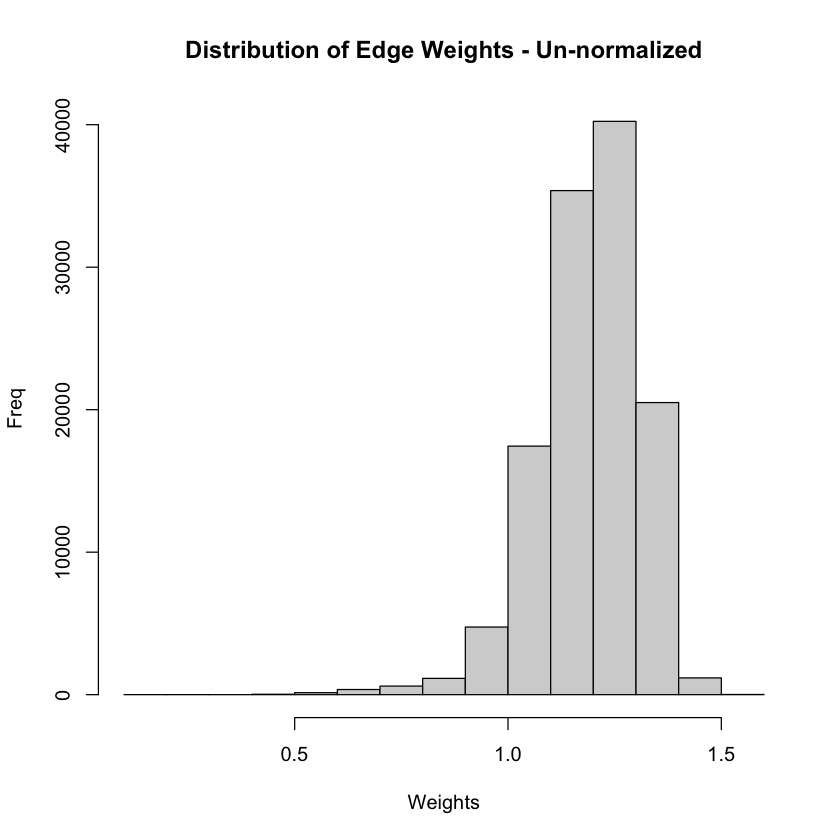

In [86]:
missingData = which(num_data != 765)
data_sectors = data_sectors[-missingData,]
weightFl <- file("finance_data/edgeDay.txt", "w")
getEdgeWeights(weightFl,mat_norm,data_sectors)
close(weightFl)

# Creating correlation graph
edgeLs <- read.delim("finance_data/edgeDay.txt", header=TRUE)
cg <- graph.data.frame(edgeLs, directed = FALSE)
E(cg)$weight <- edgeLs[,"weight"]
hist(edgeLs[,"weight"],main="Distribution of Edge Weights - Un-normalized",xlab="Weights",ylab="Freq")

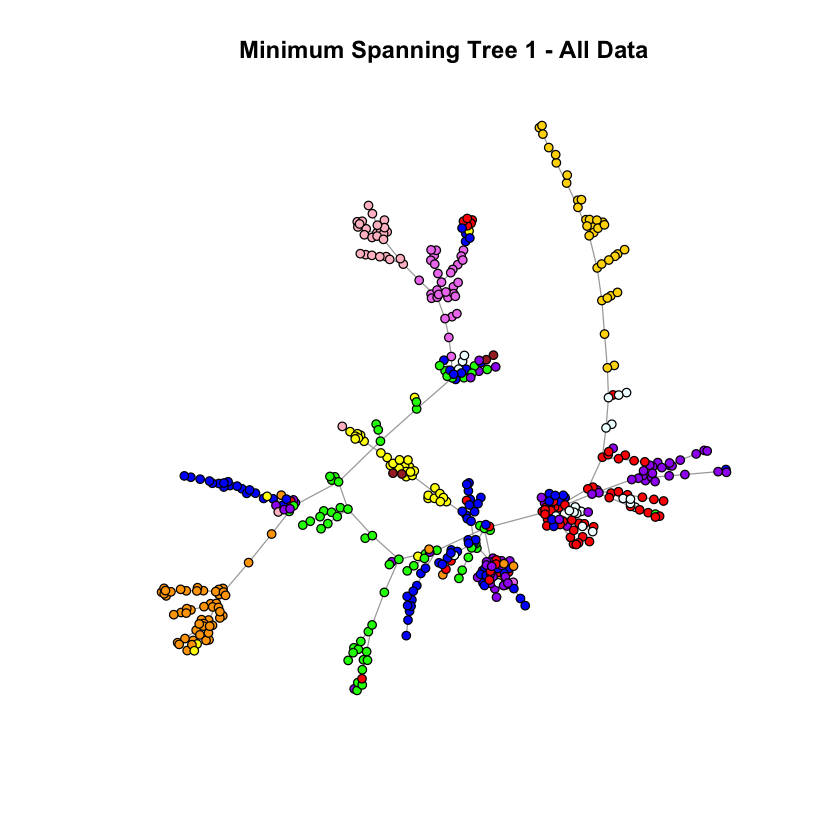

In [87]:
sect = unique(data_sectors[,2])

node_colors = list("1"="orange", "2"="red", "3"="blue", "4"="purple", "5"="yellow", "6"="pink", "7"="green", "8"="violet", "9"="azure", "10"="gold", "11"="brown")
sectCol <- c()
for (n in c(1:vcount(cg))) {
  currSect <- data_sectors[n,2]
  i <- which(sect==currSect)
  sectCol[n] <- node_colors[[i]]
}

mst <- mst(cg, algorithm = "prim")

plot(mst, vertex.size = 3, vertex.label=NA, vertex.color = sectCol, main="Minimum Spanning Tree 1 - All Data")


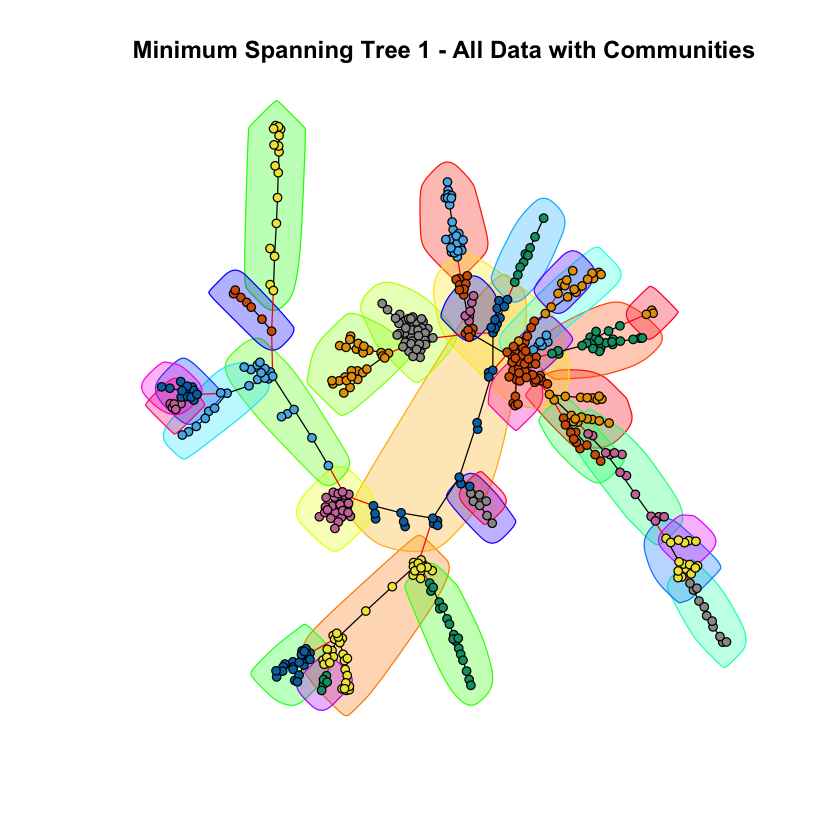

In [88]:
communities <- cluster_walktrap(mst)

plot(communities, mst, vertex.size = 3, vertex.label = NA, vertex.color = sectCol, main = "Minimum Spanning Tree 1 - All Data with Communities")

homogeneity_score <- homogeneity(data_sectors[,2], communities$membership)
completeness_score <- completeness(data_sectors[,2], communities$membership)

In [89]:
homogeneity_score

[1] 0.6826446

In [90]:
completeness_score

[1] 0.4792845

In [59]:
s_i <- sapply(sect, function(s) sum(data_sectors[, 2] == s))

pv1 <- sapply(1:vcount(mst), function(v) {
  q_i <- sum(data_sectors[neighbors(mst, v), 2] == data_sectors[v, 2])
  n_i <- length(neighbors(mst, v))
  q_i / n_i
})

pv2 <- s_i[match(data_sectors[, 2], sect)] / vcount(mst)

a1 <- mean(pv1)
a2 <- mean(pv2)

print(sprintf("alpha 1: %f", a1))
print(sprintf("alpha 2: %f", a2))

[1] "alpha 1: 0.828930"
[1] "alpha 2: 0.114188"


In [60]:
file_name_week <- list.files("finance_data/data/", pattern="*.csv")
file_name_week <- paste("finance_data/data", file_name_week, sep="/")
data_sectors_week <- read.csv(file = 'finance_data/Name_sector.csv', stringsAsFactors=FALSE, header=TRUE)

num_data_week <- c()
iter <- 1
deleteNum = 0
for(j in c(1:length(file_name_week))){
  data <- read.csv(file_name_week[j], stringsAsFactors=FALSE, header=TRUE)
  data["Day"] <- weekdays(as.Date(data[,1])) 
  data <- subset(data, Day == 'Monday')
  num_data_week[j] <- dim(data)[1]
  if (num_data_week[j] != 143) {
      deleteNum <- deleteNum + 1
  }
}

mat_norm_week <- matrix(0, length(file_name_week) - deleteNum, 142) 

for(x in c(1:length(file_name_week))) {
  data = read.csv(file_name_week[x], stringsAsFactors=FALSE, header=TRUE)
  data["Day"] = weekdays(as.Date(data[,1]))
  data = subset(data, Day == 'Monday')
  num_data_week[x] = dim(data)[1]
  if(num_data_week[x] == 143) {
      p <- data[,5] 
      q <- c()
      r <- c()
      for(y in c(2:length(p))) {
          q[y-1] <- (p[y] - p[y - 1]) / p[y - 1]
      }
      r <- log(1 + q)
      mat_norm_week[iter,] <- r
      iter <- iter + 1
  }
}

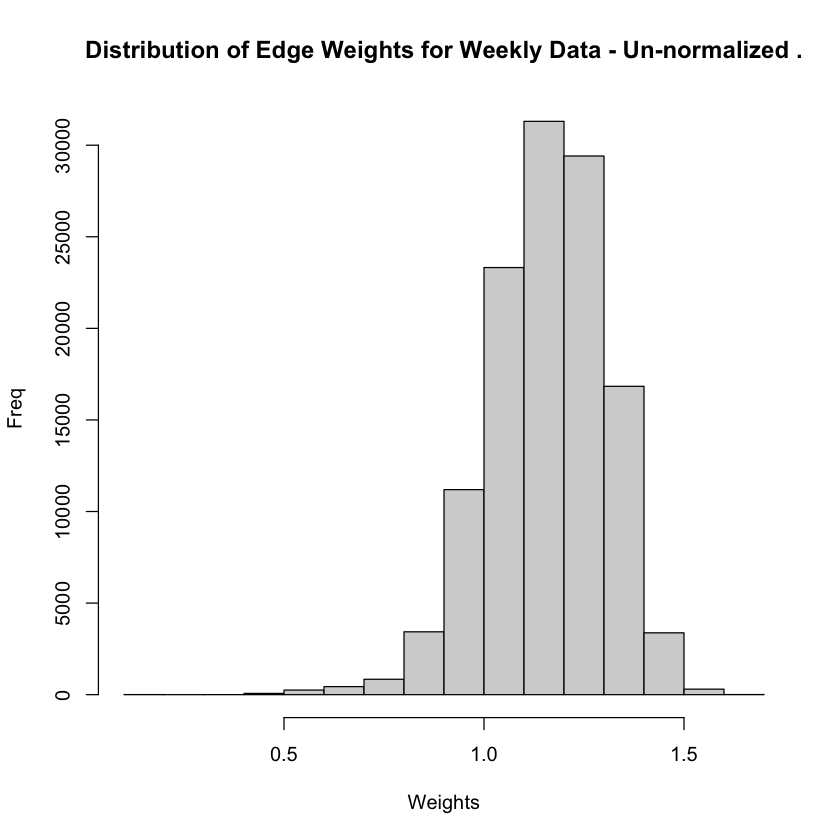

In [61]:
missingData <- which(num_data_week != 143)
data_sectors_week <- data_sectors_week[-missingData,]
weightFl <- file("finance_data/edgeWeek.txt", "w")
getEdgeWeights(weightFl, mat_norm_week, data_sectors_week)
close(weightFl)

edgeLs <- read.delim("finance_data/edgeWeek.txt", header=TRUE)
cg <- graph.data.frame(edgeLs, directed = FALSE)
E(cg)$weight <- edgeLs[,"weight"]
hist(edgeLs[,"weight"], main="Distribution of Edge Weights for Weekly Data - Un-normalized .", xlab="Weights", ylab="Freq")

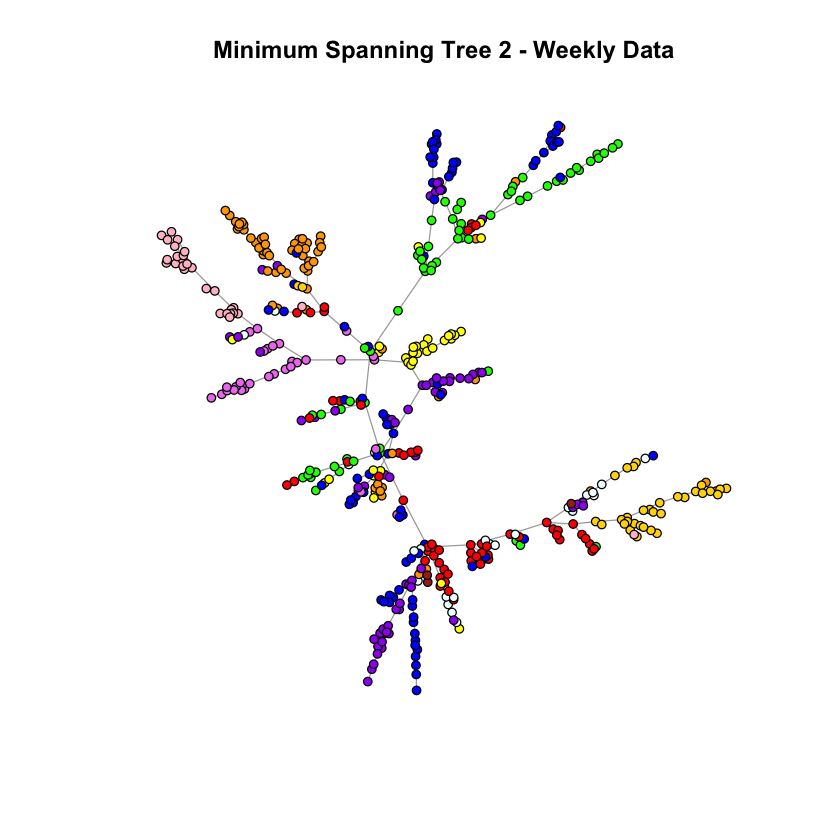

In [63]:
sectWeek <- unique(data_sectors_week[,2])

sectCol <- c()
for (n in c(1:vcount(cg))) {
  currSect <- data_sectors_week[n,2]
  i <- which(sectWeek==currSect)
  sectCol[n] <- node_colors[[i]]
}

mstWk <- mst(cg, algorithm = "prim")

plot(mstWk, vertex.size = 3, vertex.label=NA, vertex.color = sectCol, main="Minimum Spanning Tree 2 - Weekly Data")


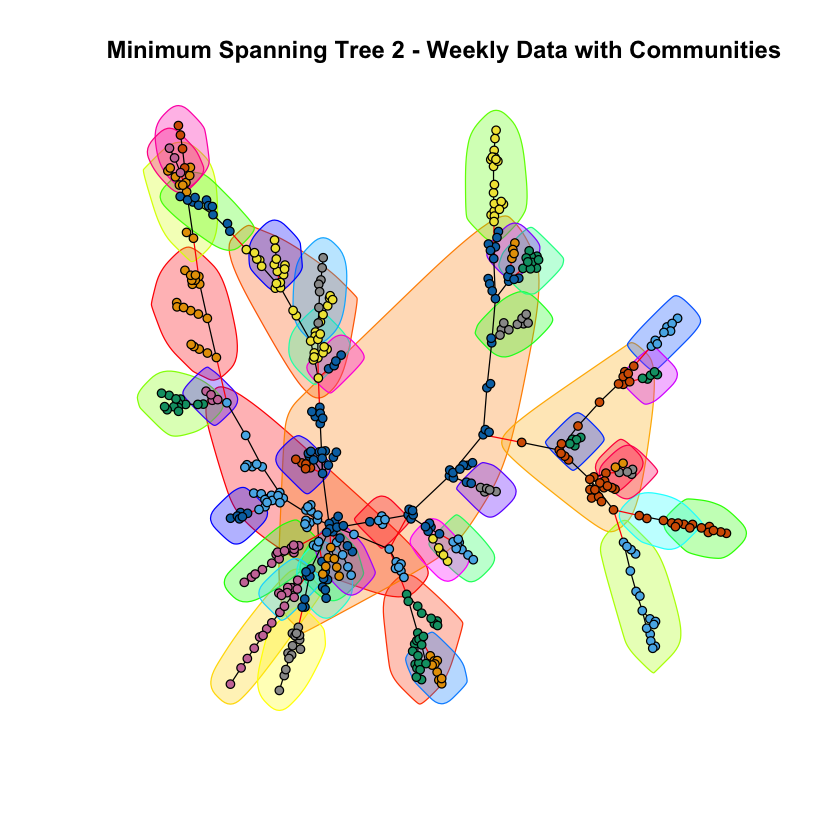

In [72]:
communities <- cluster_walktrap(mstWk)

plot(communities, mstWk, vertex.size = 3, vertex.label = NA, vertex.color = sectCol, main = "Minimum Spanning Tree 2 - Weekly Data with Communities")

homogeneity_score <- homogeneity(data_sectors_week[,2], communities$membership)
completeness_score <- completeness(data_sectors_week[,2], communities$membership)

In [73]:
homogeneity_score

[1] 0.5811237

In [74]:
completeness_score

[1] 0.3900435

In [67]:
s_i_week <- sapply(sectWeek, function(s) sum(data_sectors_week[, 2] == s))

pv1_week <- sapply(1:vcount(mstWk), function(v) {
  q_iWeek <- sum(data_sectors_week[neighbors(mstWk, v), 2] == data_sectors_week[v, 2])
  n_i_week <- length(neighbors(mstWk, v))
  q_iWeek / n_i_week
})

pv2_week <- s_i_week[match(data_sectors_week[, 2], sectWeek)] / vcount(mstWk)

a1_week <- mean(pv1_week)
a2_week <- mean(pv2_week)

print(sprintf("alpha 1: %f", a1_week))
print(sprintf("alpha 2: %f", a2_week))


[1] "alpha 1: 0.743957"
[1] "alpha 2: 0.114309"


In [77]:
file_name_month <- list.files("finance_data/data/", pattern = "*.csv")
file_name_month <- paste("finance_data/data", file_name_month, sep = "/")
data_sectors_month <- read.csv(file = "finance_data/Name_sector.csv", stringsAsFactors = FALSE, header = TRUE)

num_data_month <- c()
iter <- 1
deleteNum = 0
for(j in c(1:length(file_name_month))){
  data <- read.csv(file_name_month[j], stringsAsFactors=FALSE, header=TRUE)
  data["Day"] <- weekdays(as.Date(data[,1])) 
  data <- subset(data, format(as.Date(data[, 1]), "%d") == "15")
  num_data_month[j] <- dim(data)[1]
  if (num_data_month[j] != 25) {
      deleteNum <- deleteNum + 1
  }
}

mat_norm_month <- matrix(0, length(file_name_month) - deleteNum, 24)


# Ignoring missing data comps
for (x in c(1:length(file_name_month))) {
  data <- read.csv(file_name_month[x], stringsAsFactors = FALSE, header = TRUE)
  data["Day"] <- weekdays(as.Date(data[, 1]))
  data <- subset(data, format(as.Date(data[, 1]), "%d") == "15")
  num_data_month[x] <- dim(data)[1]
  if (num_data_month[x] == 25) {
    p <- data[, 5]
    q <- c()
    r <- c()
    for (y in 2:length(p)) {
      q[y - 1] <- (p[y] - p[y - 1]) / p[y - 1]
    }
    r <- log(1 + q)
    mat_norm_month[iter, ] <- r
    iter <- iter + 1
  }
}

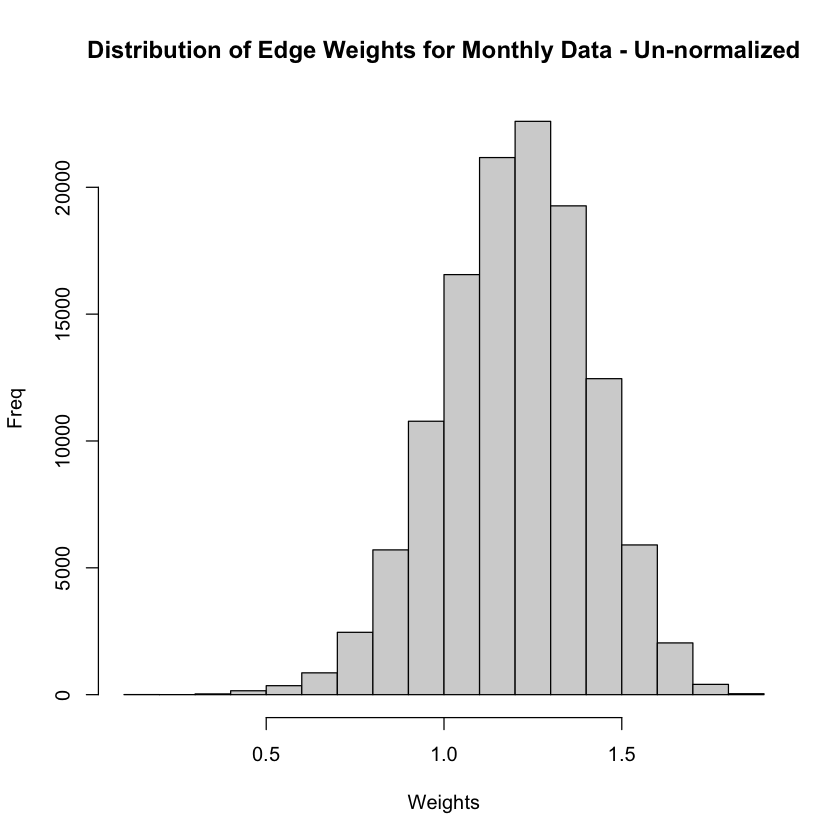

In [78]:
missingData <- which(num_data_month != 25)
data_sectors_month <- data_sectors_month[-missingData,]
weightFl <- file("finance_data/edgeMonth.txt", "w")
getEdgeWeights(weightFl, mat_norm_month, data_sectors_month)
close(weightFl)

# Creating correlation graph
edgeLs <- read.delim("finance_data/edgeMonth.txt", header = TRUE)
cg_month <- graph.data.frame(edgeLs, directed = FALSE)
E(cg_month)$weight <- edgeLs[, "weight"]
hist(edgeLs[, "weight"], main = "Distribution of Edge Weights for Monthly Data - Un-normalized", xlab = "Weights", ylab = "Freq")


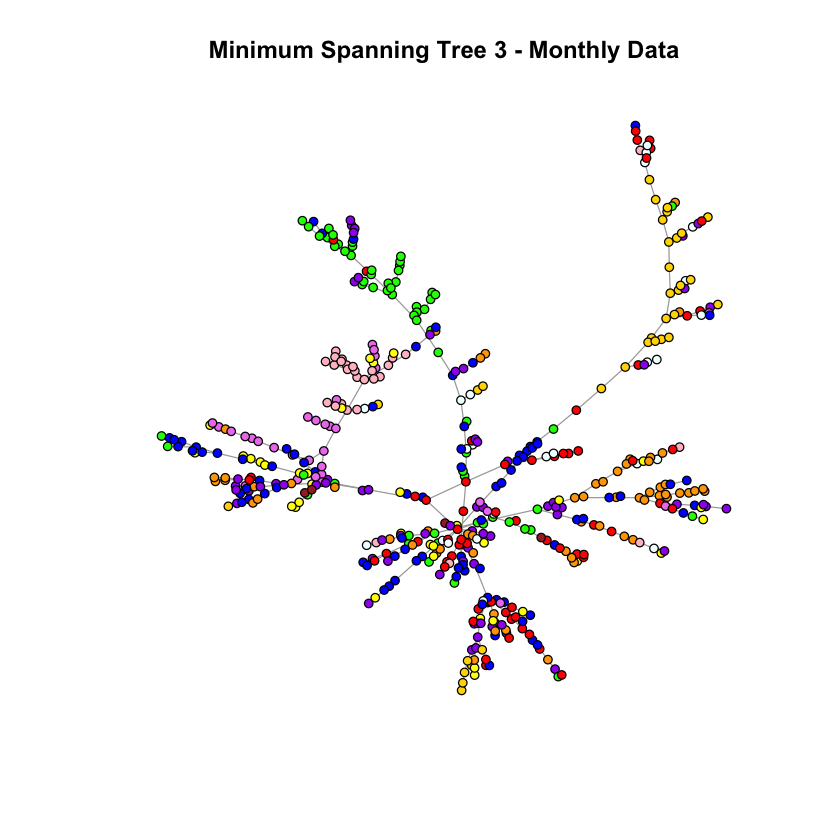

In [79]:
sectMonth <- unique(data_sectors_month[, 2])

sectCol <- c()
for (n in c(1:vcount(cg_month))) {
  currSect <- data_sectors_month[n, 2]
  i <- which(sectMonth == currSect)
  sectCol[n] <- node_colors[[i]]
}

mstMonth <- mst(cg_month, algorithm = "prim")

plot(mstMonth, vertex.size = 3, vertex.label = NA, vertex.color = sectCol, main = "Minimum Spanning Tree 3 - Monthly Data")

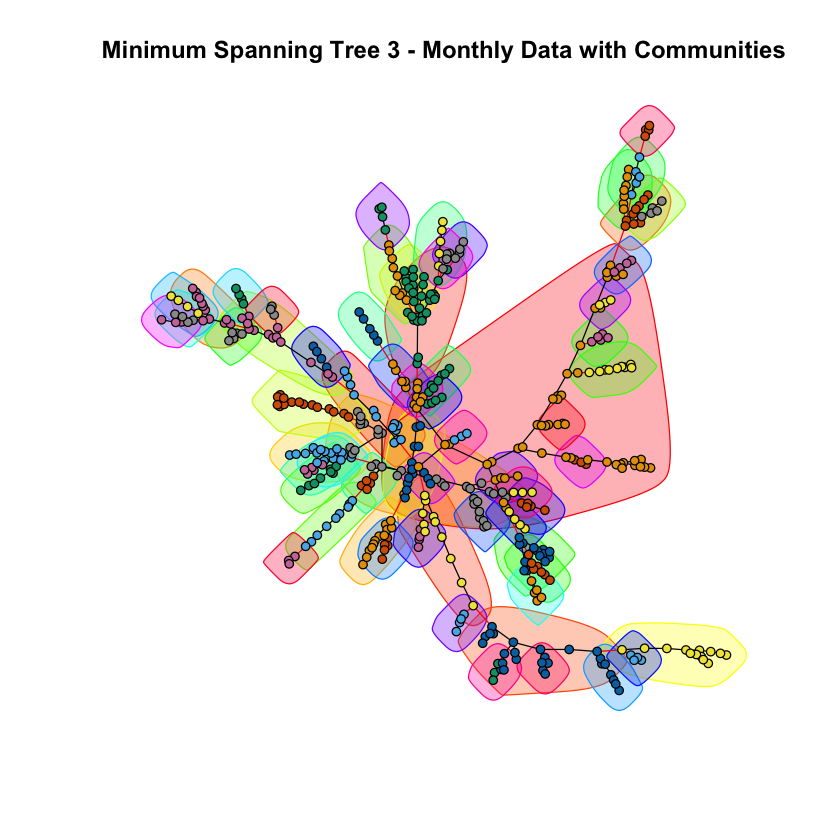

In [80]:
communities <- cluster_walktrap(mstMonth)
membership <- membership(communities)

plot(communities, mstMonth, vertex.size = 3, vertex.label = NA, vertex.color = sectCol, main = "Minimum Spanning Tree 3 - Monthly Data with Communities")

homogeneity_score <- homogeneity(data_sectors_month[,2], communities$membership)
completeness_score <- completeness(data_sectors_month[,2], communities$membership)

In [81]:
homogeneity_score

[1] 0.4794473

In [82]:
completeness_score

[1] 0.2775512

In [83]:
s_i_month <- sapply(sectMonth, function(s) sum(data_sectors_month[, 2] == s))

pv1_month <- sapply(1:length(mstMonth), function(v) {
  q_iMonth <- sum(data_sectors_month[neighbors(mstMonth, v), 2] == data_sectors_month[v, 2])
  n_i_month <- length(neighbors(mstMonth, v))
  q_iMonth / n_i_month
})

pv2_month <- s_i_month[match(data_sectors_month[, 2], sectMonth)] / vcount(mstMonth)

a1_month <- mean(pv1_month)
a2_month <- mean(pv2_month)

print(sprintf("alpha 1: %f", a1_month))
print(sprintf("alpha 2: %f", a2_month))


[1] "alpha 1: 0.484446"
[1] "alpha 2: 0.114309"
